# Value-based RL

## 1 env & utils

In [19]:
import gym
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt

sys.path.append('.')
sys.path.append('../Online RL/value-based')

In [20]:
env = gym.make('CartPole-v1')
env = env.unwrapped
A_DIM = env.action_space.n
S_DIM = env.observation_space.shape[0]
print(' State Dimensions : ', S_DIM)
print(' Action Dimensions : ', A_DIM)

 State Dimensions :  4
 Action Dimensions :  2


In [21]:
EPOCHS = 500
capacity = 2048
mini_batch = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [22]:
def move_avg(a,n=100,mode="valid"):	
    return(np.convolve(a, np.ones((n,))/n, mode=mode))	
    
def plot_G(model_name, rew): 
    plt.figure(figsize=[15, 6])
    
    plt.subplot(1,2,1)
    X = np.linspace(1,len(rew),len(rew))
    plt.plot(X, rew)
    plt.xlabel('epochs')
    plt.title(model_name)

    plt.subplot(1,2,2)
    rew = move_avg(rew, 100)
    X = np.linspace(1,len(rew),len(rew))
    plt.plot(X, rew)
    plt.xlabel('epochs')
    plt.title(model_name+'(avg)')
    plt.show()

In [23]:
def train(agent, epochs = EPOCHS):
    rew = list()
    print('\nagent learning...\n')
    for epoch in range(epochs):
        obs = env.reset()
        done = False
        final_reward = 0
        
        while not done:
            
            # env.render()
            loss = 0
            print(obs)
            action = agent.choose_action(obs, epoch)
            obs_next, _, done, info, _ = env.step(action)
            x, x_dot, theta, theta_dot = obs_next

            r1 = (env.x_threshold - abs(x)) / env.x_threshold - 0.8
            r2 = (env.theta_threshold_radians - abs(theta)) / env.theta_threshold_radians - 0.5
            reward = r1 + r2
            
            agent.buffer.add(obs, action, reward, obs_next)
            final_reward += reward
            
            if agent.buffer.counter > capacity:
                loss = agent.learn()
                if done:
                    print('Ep: ', epoch,' | reward:%.3f'%final_reward, ' | loss:%.4f'%loss)

            obs = obs_next
            
        rew.append(final_reward)
    return rew

## 2 DQN
### 2.1 DQN
For tasks (images) with high obs feature dimensions, relying solely on dynamic programming arrays to save Q values is not ideal in terms of update speed or memory usage. Therefore, deep models are introduced.

In [24]:
from DQN import Replay_buffer, DQN

replay_buffer = Replay_buffer(capacity)
dqn = DQN(n_states=S_DIM,n_actions=A_DIM, replayer_buffer=replay_buffer, mini_batch=mini_batch, device = device)

In [25]:
rew_dqn = train(dqn)

plot_G('Rewards of DQN', rew_dqn)


agent learning...



ValueError: expected sequence of length 4 at dim 2 (got 0)

### 2.2 Double DQN
In Q-learning and DQN, the same value is used for action selection and evaluation in the following formula. This will lead to a high probability of selecting an overestimated value, resulting in an overly optimistic estimate of the value.
$$
{Q_*=R_{t+1}+\gamma max_a(Q(S_{t+1}, a_t; \theta_t))}
$$

My personal understanding is that DQN uses the maximum value of the action's value to select actions and evaluate actions. Since the $Q(s^`, a^`)$ used in the update strategy is a random variable and is not stable, it always chooses the highest value when interacting with the execution environment, making the model "value" the value of the action too much and want to Increase the value as much as possible so that the value of the action is overestimated. Similar to a scholar who is eager for success and arrogant.

DDQN: The changes to DQN are as follows:
$$
{Q_*=R_{t+1}+\gamma Q^`(S_{t+1},argmax_a Q(S_{t+1}, a_t, \theta_t); \theta^`_t))}
$$


The model is more complex than DQN, and the value of the strategy needs to be comprehensively considered during backpropagation, resulting in slower learning of simple discrete actions.


In [ ]:
from DoubleDQN import Replay_buffer, Double_DQN

replay_buffer = Replay_buffer(capacity)
ddqn = Double_DQN(n_states=S_DIM, n_actions=A_DIM, replayer_buffer=replay_buffer, mini_batch=mini_batch, device = device)

In [ ]:
rew_ddqn = train(ddqn)
plot_G('Rewards of Double DQN', rew_ddqn)


agent learning...



ValueError: expected sequence of length 4 at dim 2 (got 0)

### 2.3 Prioritized Experience Replay

As the name suggests, it replaces the sampling process of the original DQN random sampling with the process of selecting experience learning with higher priority, which can effectively improve training efficiency.

In [ ]:
from DQNPER import Priority_Replay_buffer, PERDQN

replay_buffer = Priority_Replay_buffer(capacity, S_DIM)
perdqn = PERDQN(S_DIM ,A_DIM, replayer_buffer=replay_buffer,mini_batch=mini_batch, device=device)

/home/dabai/Projects/OfflineRL/RL_algorithms/notebooks/../Online RL/value-based/DQNPER.py:57: DeprecationWarning: invalid escape sequence \ 
  '''



agent learning...

Ep:  77  | reward:4.999  | loss:0.0686
Ep:  78  | reward:8.631  | loss:0.0372
Ep:  79  | reward:2.864  | loss:0.0448
Ep:  80  | reward:0.743  | loss:0.0258
Ep:  81  | reward:3.585  | loss:0.0162
Ep:  82  | reward:1.613  | loss:0.0174
Ep:  83  | reward:2.115  | loss:0.0084
Ep:  84  | reward:2.573  | loss:0.0079
Ep:  85  | reward:4.560  | loss:0.0054
Ep:  86  | reward:2.416  | loss:0.0074
Ep:  87  | reward:2.935  | loss:0.0534
Ep:  88  | reward:41.621  | loss:0.0049
Ep:  89  | reward:10.444  | loss:0.0107
Ep:  90  | reward:10.901  | loss:0.0043
Ep:  91  | reward:25.726  | loss:0.0056
Ep:  92  | reward:15.543  | loss:0.0057
Ep:  93  | reward:38.621  | loss:0.0064
Ep:  94  | reward:71.661  | loss:0.0111
Ep:  95  | reward:102.738  | loss:0.0103
Ep:  96  | reward:116.389  | loss:0.0160
Ep:  97  | reward:46.143  | loss:0.0252
Ep:  98  | reward:56.540  | loss:0.0177
Ep:  99  | reward:75.062  | loss:0.0233
Ep:  100  | reward:99.941  | loss:0.0192
Ep:  101  | reward:36.069  |

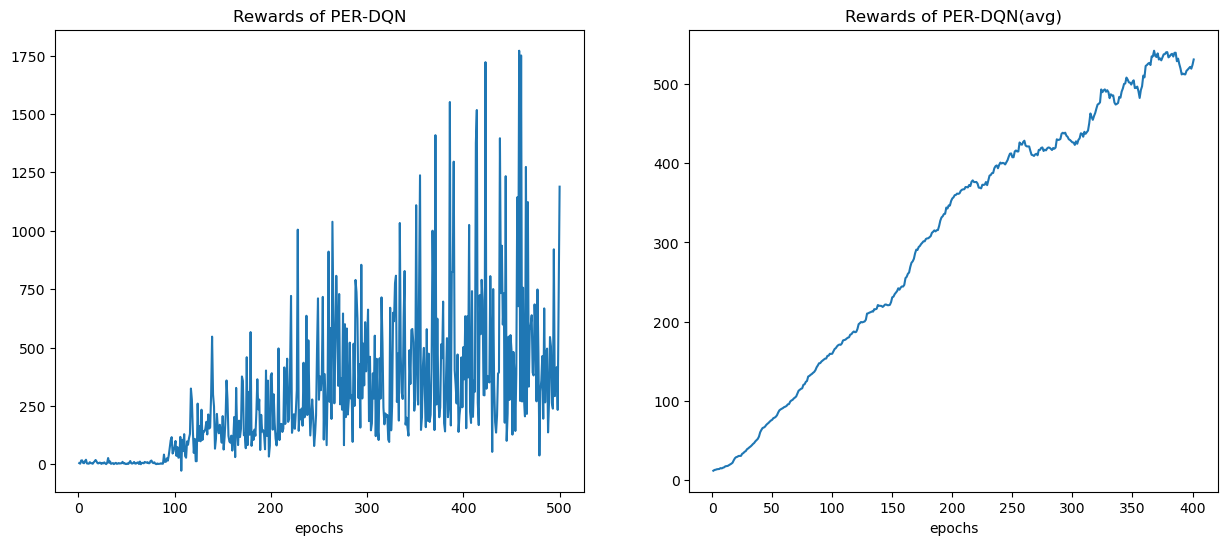

In [ ]:
rew_perdqn = train(perdqn)

plot_G('Rewards of PER-DQN', rew_perdqn)

## Dueling DQN

Compared with other DQN variants, DuelingDQN has no mathematical innovation. Instead, it divides the pure Q value output into two parts in terms of network structure.
- Advantage function A
- value function V
$$
Q(s,a;\theta,\alpha,\beta)=V(s;\theta,\beta)+A(s,a;\theta,\alpha)
$$

In order to solve the "unidentifiable" problem in the above formula (for example, V and A can get the same Q by adding and subtracting a value respectively, but in turn, it is obvious that unique V and A cannot be obtained from Q), the author forced the advantage function estimation The quantity has zero advantage at the selected action. , that is to say, let the last module of the network implement forward mapping.

$$
Q(s,a;\theta,\alpha,\beta)=V(s;\theta,\beta)+(A(s,a;\theta,\alpha)- max_{a^`\in |A|}A(s, a^`;\theta, \alpha))
$$

In [ ]:
from DuelingDQN import DuelingDQN

replay_buffer = Priority_Replay_buffer(capacity, S_DIM)

duelingdqn = DuelingDQN(S_DIM, A_DIM, replayer_buffer=replay_buffer, mini_batch=mini_batch)

/home/dabai/Projects/OfflineRL/RL_algorithms/notebooks/../Online RL/value-based/DuelingDQN.py:57: DeprecationWarning: invalid escape sequence \ 
  '''



agent learning...

Ep:  137  | reward:5.193  | loss:0.0725
Ep:  138  | reward:1.457  | loss:0.0439
Ep:  139  | reward:3.665  | loss:0.0316
Ep:  140  | reward:11.905  | loss:0.0179
Ep:  141  | reward:3.020  | loss:0.0193
Ep:  142  | reward:2.862  | loss:0.0133
Ep:  143  | reward:3.315  | loss:0.0108
Ep:  144  | reward:3.844  | loss:0.0247
Ep:  145  | reward:3.578  | loss:0.0094
Ep:  146  | reward:8.778  | loss:0.0031
Ep:  147  | reward:2.961  | loss:0.0024
Ep:  148  | reward:1.885  | loss:0.0027
Ep:  149  | reward:2.589  | loss:0.0528
Ep:  150  | reward:14.342  | loss:0.0029
Ep:  151  | reward:27.764  | loss:0.0022
Ep:  152  | reward:94.857  | loss:0.0108
Ep:  153  | reward:134.091  | loss:0.0070
Ep:  154  | reward:79.029  | loss:0.0117
Ep:  155  | reward:44.923  | loss:0.0101
Ep:  156  | reward:39.624  | loss:0.0087
Ep:  157  | reward:48.985  | loss:0.0103
Ep:  158  | reward:542.571  | loss:0.0076
Ep:  159  | reward:194.691  | loss:0.0042
Ep:  160  | reward:63.451  | loss:0.0059
Ep:  

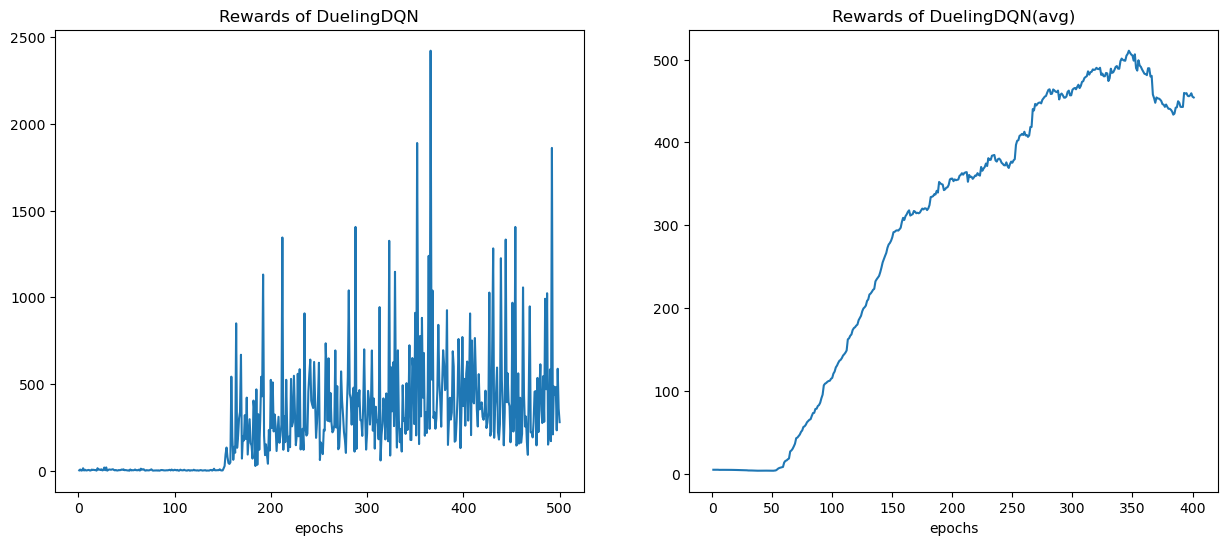

In [ ]:
rew_duelingdqn = train(duelingdqn)

plot_G('Rewards of DuelingDQN', rew_duelingdqn)

In [ ]:
import seaborn as sns

sns.set(style="darkgrid", font_scale=1.5)
fig = plt.figure(figsize=[10, 6])
xdata = np.linspace(0, 500, 500)
linestyle = ['-', '--', ':', '-.']
color = ['r', 'g', 'b', 'k']
label = ['DQN', 'Double DQN', 'PERDQN', 'DuelingDQN']

rew = [move_avg(rew_dqn), move_avg(rew_ddqn), move_avg(rew_perdqn), move_avg(rew_duelingdqn)]
for i in range(4):   
    sns.tsplot(data=rew[i], color=color[i], linestyle=linestyle[i], condition=label[i])


ModuleNotFoundError: No module named 'seaborn'